### Imports

In [118]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
import keras_tuner as kt

### Load Data

In [119]:
# Directory containing the files
folder_path = '/Users/ThomasMelkeraaen/Desktop/Project/all_data'

# Get a list of all CSV files in the directory
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Categorize files based on their names
data_files = [f for f in all_files if 'data' in f]
info_files = [f for f in all_files if 'info' in f]
KPI_files = [f for f in all_files if 'KPI' in f]

In [120]:
# Function to load files into data frames
def load_files(file_list, folder):
    data_frames = {}
    for file_name in file_list:
        file_path = os.path.join(folder, file_name)
        # Using the filename (without extension) as the key
        df_name = os.path.splitext(file_name)[0]
        data_frames[df_name] = pd.read_csv(file_path)
    return data_frames

# Load the files into dictionaries of DataFrames
data_dfs = load_files(data_files, folder_path)
info_dfs = load_files(info_files, folder_path)
KPI_dfs = load_files(KPI_files, folder_path)

### Preprocess the data

In [121]:
# Filter the "Battery Potential / V" column in each DataFrame in data_dfs
for key in data_dfs:
    if "Battery Potential / V" in data_dfs[key].columns:
        data_dfs[key] = data_dfs[key][["Battery Potential / V"]]  # Keep only the desired column
    else:
        print(f"'Battery Potential / V' column not found in {key}, removing this DataFrame.")
        del data_dfs[key]  # Remove the DataFrame if the column is not found

In [122]:
# Combine all DataFrames into a single DataFrame by stacking rows
def combine_dataframes_vertically(data_frames):
    combined_df = pd.concat(
        [df.assign(FileName=name) for name, df in data_frames.items()],
        ignore_index=True
    )
    return combined_df

# Usage
data_combined = combine_dataframes_vertically(data_dfs)
info_combined = combine_dataframes_vertically(info_dfs)
KPI_combined = combine_dataframes_vertically(KPI_dfs)

In [123]:
# Reshape the combined DataFrame
def restructure_dataframe(df):
    # Group by 'FileName' and aggregate 'Battery Potential / V' into lists
    reshaped_data = df.groupby('FileName')['Battery Potential / V'].apply(list).to_dict()
    return reshaped_data

# Apply the function to the combined data
reshaped_data_combined = restructure_dataframe(data_combined)


reshaped_data_combined_df = pd.DataFrame.from_dict(reshaped_data_combined, orient='index').transpose()

In [124]:
# Function to reshape the info_combined DataFrame
def restructure_info_dataframe(df):
    # Group by FileName
    grouped = df.groupby('FileName')
    result = {}
    
    # For each group, create a new DataFrame with variables as keys and their values
    for file_name, group in grouped:
        # Create a new DataFrame with the first column as keys and second column as values
        reformatted_df = pd.DataFrame(group.iloc[:, :2].values, columns=['Variable', 'Value'])
        result[file_name] = reformatted_df.set_index('Variable')['Value'].to_frame().T  # Convert to DataFrame with keys as columns
    
    return result

# Reshape the info_combined DataFrame
info_dict = restructure_info_dataframe(info_combined)

all_info_df = pd.concat(info_dict.values(), keys=info_dict.keys(), names=['FileName'])

all_info_df = all_info_df.drop(columns='Observation')

### Check Data Frames

In [125]:
KPI_combined

,Extraction Efficiency,Voltaic Efficiency,FileName
0,0.989458,0.989434,46984496298780185759446064746818878459_KPI
1,0.988859,0.986359,83295176127964917753086296271298198696_KPI
2,0.989018,0.997929,26644510629002426199861358177262182521_KPI
3,0.989375,0.976299,41313900686033010755756297580672109542_KPI
4,0.988624,0.997742,25903399806725668075778788499897660615_KPI
...,...,...,...
1356,0.988952,-inf,176168728962346206247309474711817861878_KPI
1357,0.989359,0.997060,18552839752566905129324929267064954233_KPI
1358,0.979812,0.972060,250261725943206245356643276765875601034_KPI
1359,0.989748,0.962144,121401671000963775661606878570374972852_KPI


In [126]:
all_info_df

,Variable,Thickness Electrolyte / m,Thickness Cathode / m,Area Battery / m^2,DAB_cathode / m^2 s^-1,DB_cathode / m^2 s^-1,Cmax Cathode / mol m^3,x min / Dimensionless,x max / Dimensionless,C_Anode / mol m^3,Anode Resistivity / Ohm cm2,...,Ref. Capacity / Ah,C0 Cathode / mol m^-3,Current / A,Current Density / A m^-2,Time_min / s,Time_max / s,Time Step Size / s,Space_Steps / Dimensionless,dz / m,Ponto
FileName,,,,,,,,,,,,,,,,,,,,,,
100216305463734118309191734766221980808_info,Value,3.1622105662634564e-6,3.043562785617931e-6,0.000336,7.0375880277113496e-12,7.0375880277113496e-12,94466.3835588203,0.5,1,76400,18.3,...,0.0012945762397826,94466.3835588203,0.019266477796628552,57.34070772806117,0,239.4765544220319,1.1973827721101595,101,0.01,24
10027480378016661343929148643629512668_info,Value,2.648728778804321e-6,2.2482075105651305e-6,0.000336,6.7209641834323475e-12,6.7209641834323475e-12,92409.06300042622,0.5,1,76400,18.3,...,0.0009354466799583768,92409.06300042622,0.0009258996052037568,2.755653586915943,0,3600.748881017157,18.003744405085786,101,0.01,8
100729839013813546683269324268531072261_info,Value,6.03560440300035e-6,3.134059516978053e-6,0.000336,3.0455297148166764e-13,3.0455297148166764e-13,92953.24211464223,0.5,1,76400,18.3,...,0.0013117161290496552,92953.24211464223,0.017317354826478486,51.53974650737645,0,269.9578735191644,1.3497893675958221,101,0.01,7
100816189648572204757228923394211932183_info,Value,9.758569747541557e-6,5.384598525507992e-6,0.000336,7.407535358491814e-12,7.407535358491814e-12,21538.383350280987,0.5,1,76400,18.3,...,0.0005221971621972726,10769.191675140493,-0.002549743173245654,-7.5885213489454,0,729.9208428517956,3.6496042142589777,101,0.01,30
100906250110897727644402819748152851087_info,Value,1.3675480455693384e-6,4.853268117652856e-6,0.000336,3.210814255865908e-12,3.210814255865908e-12,47666.04037962971,0.5,1,76400,18.3,...,0.0010416251035529722,47666.04037962971,0.012764791856853546,37.99045195492127,0,290.82745027836813,1.4541372513918407,101,0.01,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99175425091618894586075698171718036219_info,Value,8.764342899084375e-6,8.433374257155996e-6,0.000336,8.603079304890773e-12,8.603079304890773e-12,69891.91516753794,0.5,1,76400,18.3,...,0.002653972338263746,69891.91516753794,0.0008591137642742384,2.556886203197138,0,11009.90090824881,55.04950454124405,101,0.01,19
99510831126502546261628943604360857983_info,Value,9.28751800444678e-6,2.046286889223924e-6,0.000336,6.893141541383031e-12,6.893141541383031e-12,16351.68747533285,0.5,1,76400,18.3,...,0.00015065972718049977,16351.68747533285,1.6933409635542537e-6,0.005039705248673375,0,317095.7764727207,1585.4788823636036,101,0.01,263
99622741570068082855828207784931076638_info,Value,8.557103321844339e-6,8.519961323671835e-6,0.000336,8.1257524235544e-12,8.1257524235544e-12,71407.76064440697,0.5,1,76400,18.3,...,0.0027393726411460186,35703.880322203484,-0.007199480241267846,-21.427024527582876,0,1356.087351567632,6.780436757838159,101,0.01,259


In [127]:
reshaped_data_combined_df # values here are Battery potential

,100216305463734118309191734766221980808_data,10027480378016661343929148643629512668_data,100729839013813546683269324268531072261_data,100816189648572204757228923394211932183_data,100906250110897727644402819748152851087_data,101035167099556609912246434733684249517_data,101089083203342955763074728890648112167_data,101393491219580782970232925606784547126_data,10168839730028838830826719387718253301_data,101732044889977723383190815894734992692_data,...,96993297793160283141475899857606275482_data,9699374145051736475253107440671377043_data,97303201637456622485227807538534752923_data,98120923686818761430264768541476590612_data,98548791650404679072785298046808880077_data,99175425091618894586075698171718036219_data,99510831126502546261628943604360857983_data,99622741570068082855828207784931076638_data,99644618726009532454839517572610028401_data,99964048758769995211680884804800827381_data
0,3.104934,2.935865,3.961536,4.147181,3.401333,4.163422,3.932066,4.145879,2.947874,4.154970,...,3.510802,3.375801,3.933293,3.335157,3.866232,2.937667,2.885793,4.092044,3.246444,4.177384
1,3.646617,3.310318,4.148560,4.140991,3.951027,4.158681,4.259652,4.138287,3.646333,4.131905,...,3.983636,3.949062,3.926260,3.933622,3.861924,3.394848,3.237519,4.087570,3.884950,4.171810
2,3.770336,3.533198,4.168976,4.136359,3.990572,4.155314,4.301377,4.133729,3.722607,4.122691,...,4.016698,3.985647,3.921735,3.972948,3.857809,3.572499,3.491331,4.083126,3.897336,4.167314
3,3.831383,3.649015,4.179366,4.131921,4.006188,4.151361,4.319301,4.129340,3.746626,4.115845,...,4.030942,4.003532,3.917328,3.990598,3.853422,3.670209,3.624575,4.078707,3.906471,4.162902
4,3.866744,3.704681,4.185010,4.127572,4.017985,4.147182,4.328917,4.125027,3.757280,4.110200,...,4.040663,4.012187,3.913000,4.000380,3.849045,3.717682,3.689511,4.074352,3.917927,4.158559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,4.293509,4.175219,4.343748,2.855375,4.270035,3.675110,4.580937,-inf,4.172707,-inf,...,4.296902,4.286846,-inf,4.252573,3.410898,4.180927,4.169731,3.612108,4.263009,-inf
198,4.297738,4.179496,4.348438,-inf,4.274385,3.666659,4.585189,-inf,4.176987,-inf,...,4.301267,4.291173,-inf,4.256909,3.401519,4.185212,4.174014,3.595562,4.267309,-inf
199,4.302029,4.183837,4.353203,-inf,4.278800,3.661118,4.589503,-inf,4.181331,-inf,...,4.305698,4.295565,-inf,4.261310,3.393934,4.189561,4.178361,3.561085,4.271673,-inf
200,4.306384,4.188243,4.358046,-inf,4.283283,3.660198,4.593882,-inf,4.185741,-inf,...,4.310197,4.300024,-inf,4.265779,3.390499,4.193976,4.182774,3.487491,4.276103,-inf


### Rename for future code

In [128]:
KPI = KPI_combined.reset_index()
Info = all_info_df.reset_index()
data = reshaped_data_combined_df.reset_index()

In [129]:
print("all_info_df FileName examples:")
print(Info["FileName"].head())
print("\nKPI_combined FileName examples:")
print(KPI["FileName"].head())

all_info_df FileName examples:
0    100216305463734118309191734766221980808_info
1     10027480378016661343929148643629512668_info
2    100729839013813546683269324268531072261_info
3    100816189648572204757228923394211932183_info
4    100906250110897727644402819748152851087_info
Name: FileName, dtype: object

KPI_combined FileName examples:
0    46984496298780185759446064746818878459_KPI
1    83295176127964917753086296271298198696_KPI
2    26644510629002426199861358177262182521_KPI
3    41313900686033010755756297580672109542_KPI
4    25903399806725668075778788499897660615_KPI
Name: FileName, dtype: object


In [130]:
# Clean the 'FileName' columns in both DataFrames to match the identifiers
Info['FileName_clean'] = Info['FileName'].str.replace('_info', '')
KPI['FileName_clean'] = KPI['FileName'].str.replace('_KPI', '')

# Merge the DataFrames on the cleaned 'FileName'
merged_df = pd.merge(Info, KPI, left_on='FileName_clean', right_on='FileName_clean')

# Drop the 'FileName_clean' column as it is no longer needed
merged_df = merged_df.drop(columns=['FileName_clean'])

# Verify the merge
merged_df.head()

,FileName_x,level_1,Thickness Electrolyte / m,Thickness Cathode / m,Area Battery / m^2,DAB_cathode / m^2 s^-1,DB_cathode / m^2 s^-1,Cmax Cathode / mol m^3,x min / Dimensionless,x max / Dimensionless,...,Time_min / s,Time_max / s,Time Step Size / s,Space_Steps / Dimensionless,dz / m,Ponto,index,Extraction Efficiency,Voltaic Efficiency,FileName_y
0,100216305463734118309191734766221980808_info,Value,3.1622105662634564e-6,3.043562785617931e-6,0.000336,7.0375880277113496e-12,7.0375880277113496e-12,94466.3835588203,0.5,1,...,0,239.4765544220319,1.1973827721101595,101,0.01,24,831,0.989797,0.967181,100216305463734118309191734766221980808_KPI
1,10027480378016661343929148643629512668_info,Value,2.648728778804321e-6,2.2482075105651305e-6,0.000336,6.7209641834323475e-12,6.7209641834323475e-12,92409.06300042622,0.5,1,...,0,3600.748881017157,18.003744405085786,101,0.01,8,1090,0.989095,0.998086,10027480378016661343929148643629512668_KPI
2,100729839013813546683269324268531072261_info,Value,6.03560440300035e-6,3.134059516978053e-6,0.000336,3.0455297148166764e-13,3.0455297148166764e-13,92953.24211464223,0.5,1,...,0,269.9578735191644,1.3497893675958221,101,0.01,7,1072,0.980006,0.945728,100729839013813546683269324268531072261_KPI
3,100816189648572204757228923394211932183_info,Value,9.758569747541557e-6,5.384598525507992e-6,0.000336,7.407535358491814e-12,7.407535358491814e-12,21538.383350280987,0.5,1,...,0,729.9208428517956,3.6496042142589777,101,0.01,30,294,0.974170,0.984938,100816189648572204757228923394211932183_KPI
4,100906250110897727644402819748152851087_info,Value,1.3675480455693384e-6,4.853268117652856e-6,0.000336,3.210814255865908e-12,3.210814255865908e-12,47666.04037962971,0.5,1,...,0,290.82745027836813,1.4541372513918407,101,0.01,40,889,0.989612,0.968616,100906250110897727644402819748152851087_KPI


In [131]:
print(merged_df['Extraction Efficiency'].max())
merged_df['Extraction Efficiency'].min()

0.990207668238552


0.0148538842423648

### Remove NaN values and infinite values

In [132]:
# Remove rows with any NaN values
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
merged_df = merged_df.dropna()
merged_df.isnull().values.any()

False

### Plot

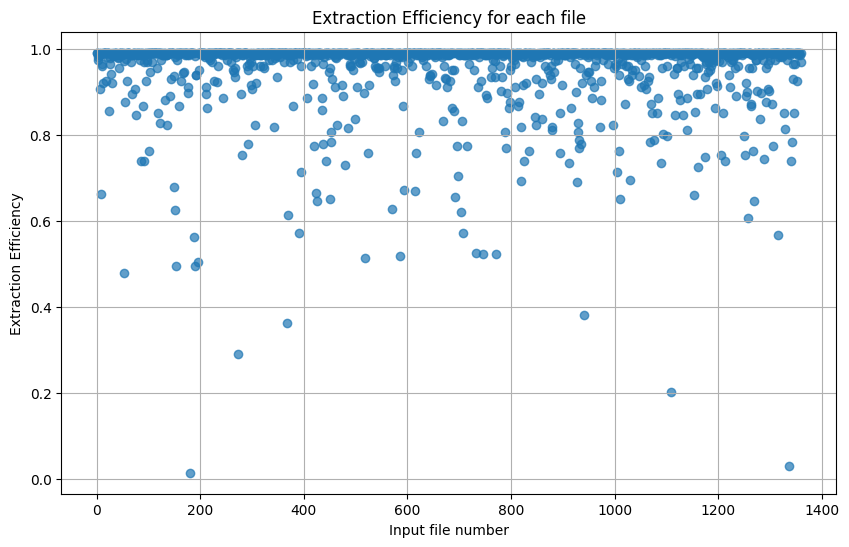

In [133]:
# Example: FileName_x vs. Extraction Efficiency
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["FileName_x"].index, merged_df["Extraction Efficiency"], alpha=0.7)
plt.xlabel("Input file number")
plt.ylabel("Extraction Efficiency")
plt.title("Extraction Efficiency for each file")
plt.grid(True)
plt.show()

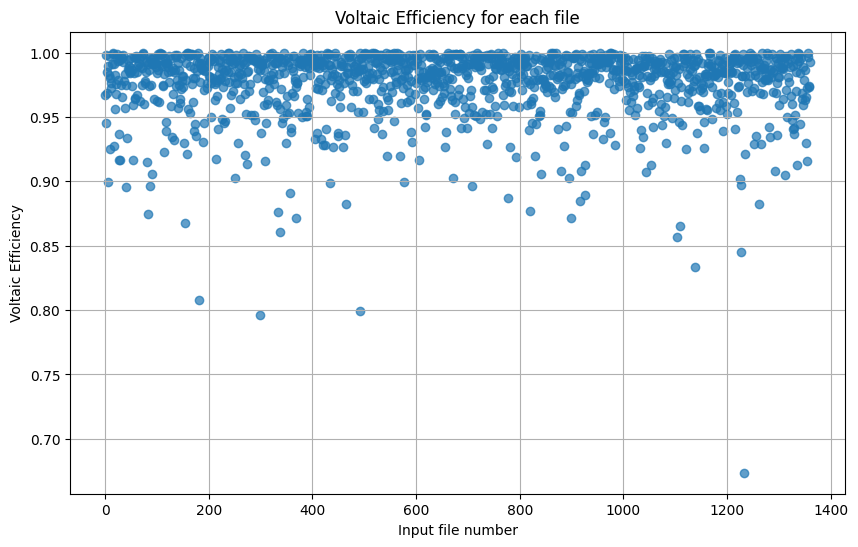

In [134]:
# Example: FileName_x vs. Voltaic Efficiency
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["FileName_x"].index, merged_df["Voltaic Efficiency"], alpha=0.7)
plt.xlabel("Input file number")
plt.ylabel("Voltaic Efficiency")
plt.title("Voltaic Efficiency for each file")
plt.grid(True)
plt.show()

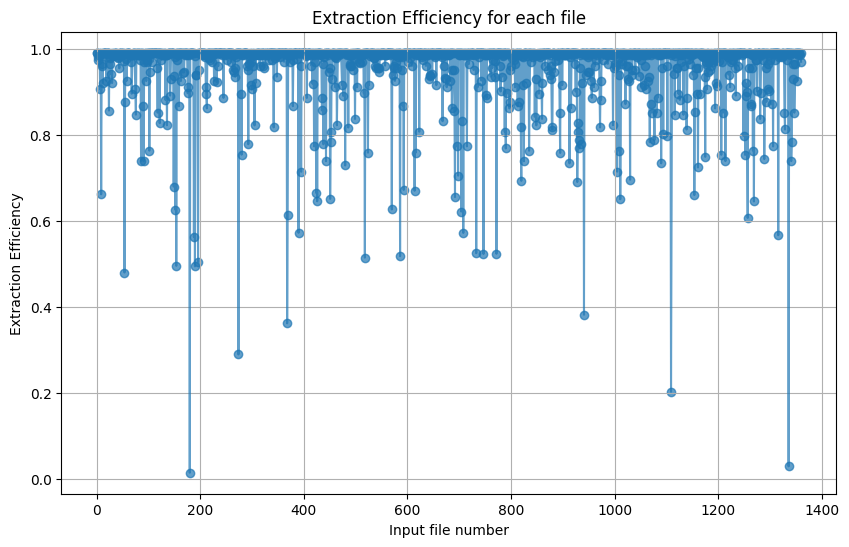

In [135]:
# Example: FileName_x vs. Extraction Efficiency
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["FileName_x"].index, merged_df["Extraction Efficiency"], alpha=0.7)
plt.plot(merged_df["FileName_x"].index, merged_df["Extraction Efficiency"], linestyle='-', alpha=0.7)
plt.xlabel("Input file number")
plt.ylabel("Extraction Efficiency")
plt.title("Extraction Efficiency for each file")
plt.grid(True)
plt.show()

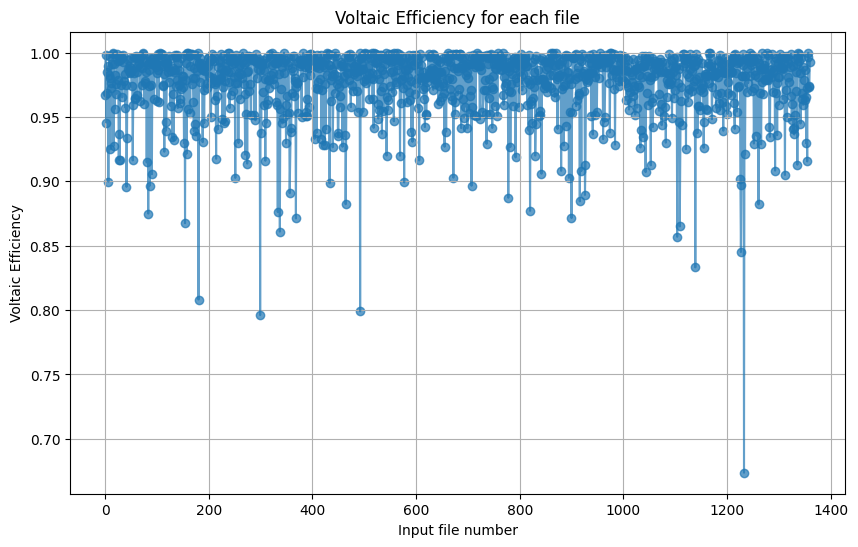

In [136]:
# Example: FileName_x vs. Voltaic Efficiency
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["FileName_x"].index, merged_df["Voltaic Efficiency"], alpha=0.7)
plt.plot(merged_df["FileName_x"].index, merged_df["Voltaic Efficiency"], linestyle='-', alpha=0.7)
plt.xlabel("Input file number")
plt.ylabel("Voltaic Efficiency")
plt.title("Voltaic Efficiency for each file")
plt.grid(True)
plt.show()

In [137]:
merged_df

,FileName_x,level_1,Thickness Electrolyte / m,Thickness Cathode / m,Area Battery / m^2,DAB_cathode / m^2 s^-1,DB_cathode / m^2 s^-1,Cmax Cathode / mol m^3,x min / Dimensionless,x max / Dimensionless,...,Time_min / s,Time_max / s,Time Step Size / s,Space_Steps / Dimensionless,dz / m,Ponto,index,Extraction Efficiency,Voltaic Efficiency,FileName_y
0,100216305463734118309191734766221980808_info,Value,3.1622105662634564e-6,3.043562785617931e-6,0.000336,7.0375880277113496e-12,7.0375880277113496e-12,94466.3835588203,0.5,1,...,0,239.4765544220319,1.1973827721101595,101,0.01,24,831,0.989797,0.967181,100216305463734118309191734766221980808_KPI
1,10027480378016661343929148643629512668_info,Value,2.648728778804321e-6,2.2482075105651305e-6,0.000336,6.7209641834323475e-12,6.7209641834323475e-12,92409.06300042622,0.5,1,...,0,3600.748881017157,18.003744405085786,101,0.01,8,1090,0.989095,0.998086,10027480378016661343929148643629512668_KPI
2,100729839013813546683269324268531072261_info,Value,6.03560440300035e-6,3.134059516978053e-6,0.000336,3.0455297148166764e-13,3.0455297148166764e-13,92953.24211464223,0.5,1,...,0,269.9578735191644,1.3497893675958221,101,0.01,7,1072,0.980006,0.945728,100729839013813546683269324268531072261_KPI
3,100816189648572204757228923394211932183_info,Value,9.758569747541557e-6,5.384598525507992e-6,0.000336,7.407535358491814e-12,7.407535358491814e-12,21538.383350280987,0.5,1,...,0,729.9208428517956,3.6496042142589777,101,0.01,30,294,0.974170,0.984938,100816189648572204757228923394211932183_KPI
4,100906250110897727644402819748152851087_info,Value,1.3675480455693384e-6,4.853268117652856e-6,0.000336,3.210814255865908e-12,3.210814255865908e-12,47666.04037962971,0.5,1,...,0,290.82745027836813,1.4541372513918407,101,0.01,40,889,0.989612,0.968616,100906250110897727644402819748152851087_KPI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,99175425091618894586075698171718036219_info,Value,8.764342899084375e-6,8.433374257155996e-6,0.000336,8.603079304890773e-12,8.603079304890773e-12,69891.91516753794,0.5,1,...,0,11009.90090824881,55.04950454124405,101,0.01,19,1172,0.989749,0.996555,99175425091618894586075698171718036219_KPI
1357,99510831126502546261628943604360857983_info,Value,9.28751800444678e-6,2.046286889223924e-6,0.000336,6.893141541383031e-12,6.893141541383031e-12,16351.68747533285,0.5,1,...,0,317095.7764727207,1585.4788823636036,101,0.01,263,927,0.989612,0.999868,99510831126502546261628943604360857983_KPI
1358,99622741570068082855828207784931076638_info,Value,8.557103321844339e-6,8.519961323671835e-6,0.000336,8.1257524235544e-12,8.1257524235544e-12,71407.76064440697,0.5,1,...,0,1356.087351567632,6.780436757838159,101,0.01,259,1089,0.984381,0.973907,99622741570068082855828207784931076638_KPI
1359,99644618726009532454839517572610028401_info,Value,3.0950232913005704e-6,3.0120293061788573e-6,0.000336,3.4923216478609913e-12,3.4923216478609913e-12,68841.7324951874,0.5,1,...,0,262.6423603373408,1.313211801686704,101,0.01,43,1255,0.989443,0.973009,99644618726009532454839517572610028401_KPI


### Model training

In [138]:
# Select the features (input variables) and output variables
features_list = [
    'Thickness Electrolyte / m', 'Thickness Cathode / m', 
    'DAB_cathode / m^2 s^-1', 'DB_cathode / m^2 s^-1', 'Cmax Cathode / mol m^3', 'DA_electrolyte / m^2 s^-1', 'DB_electrolyte / m^2 s^-1',
    'C0 Electrolyte/ mol m^-3', 'δ_Electrolyte / Dimensionless', 'Kd_electrolyte / m^3 mol^-1 s^-1',
    'ka_electrolyte / s^-1', 'k_positive', 'Alfa_Positive / Dimensionless',
    'k_negative', 'Alfa_Negative / Dimensionless', 'C Rate / Dimensionless',
    'x0 / Dimensionless', 'Ref. Capacity / Ah', 'C0 Cathode / mol m^-3',
    'Current / A', 'Current Density / A m^-2', 'Time_max / s',
    'Time Step Size / s', 'Ponto'
]
features = merged_df[features_list]
labels = merged_df[['Extraction Efficiency', 'Voltaic Efficiency']]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=101)

#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [139]:
# Step 1: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_layer_1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_layer_1', values=['relu', 'tanh']),
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout_layer_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(
        units=hp.Int('units_layer_2', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_layer_2', values=['relu', 'tanh']),
    ))
    model.add(Dropout(hp.Float('dropout_layer_2', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(2, activation='linear'))  # Assuming 2 output features

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Step 2: Set up the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='kt_tuner_dir',
    project_name='model_tuning'
)

# Step 3: Perform the search
tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=2)

# Step 4: Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

'''print(f"Best hyperparameters:")
print(f"Units (Layer 1): {best_hps.get('units_layer_1')}")
print(f"Activation (Layer 1): {best_hps.get('activation_layer_1')}")
print(f"Dropout (Layer 1): {best_hps.get('dropout_layer_1')}")
print(f"Units (Layer 2): {best_hps.get('units_layer_2')}")
print(f"Activation (Layer 2): {best_hps.get('activation_layer_2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")'''

print("Best Hyperparameters Found:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

# Step 5: Train the final model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (validation loss)
    patience=5,            # Number of epochs to wait without improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best metric
)

history = best_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=2)

# Step 6: Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Reloading Tuner from kt_tuner_dir/model_tuning/tuner0.json
Best Hyperparameters Found:
units_layer_1: 160
activation_layer_1: relu
dropout_layer_1: 0.30000000000000004
units_layer_2: 64
activation_layer_2: relu
dropout_layer_2: 0.0
learning_rate: 0.01


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24/24 - 2s - 90ms/step - loss: 0.1320 - mae: 0.2530 - val_loss: 0.0107 - val_mae: 0.0775
Epoch 2/50
24/24 - 0s - 5ms/step - loss: 0.0225 - mae: 0.1173 - val_loss: 0.0079 - val_mae: 0.0657
Epoch 3/50
24/24 - 0s - 6ms/step - loss: 0.0143 - mae: 0.0933 - val_loss: 0.0061 - val_mae: 0.0513
Epoch 4/50
24/24 - 0s - 5ms/step - loss: 0.0122 - mae: 0.0873 - val_loss: 0.0063 - val_mae: 0.0519
Epoch 5/50
24/24 - 0s - 5ms/step - loss: 0.0113 - mae: 0.0816 - val_loss: 0.0057 - val_mae: 0.0501
Epoch 6/50
24/24 - 0s - 5ms/step - loss: 0.0107 - mae: 0.0777 - val_loss: 0.0075 - val_mae: 0.0664
Epoch 7/50
24/24 - 0s - 5ms/step - loss: 0.0079 - mae: 0.0654 - val_loss: 0.0097 - val_mae: 0.0809
Epoch 8/50
24/24 - 0s - 5ms/step - loss: 0.0075 - mae: 0.0632 - val_loss: 0.0046 - val_mae: 0.0405
Epoch 9/50
24/24 - 0s - 5ms/step - loss: 0.0059 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0335
Epoch 10/50
24/24 - 0s - 5ms/step - loss: 0.0058 - mae: 0.0536 - val_loss: 0.0060 - val_mae: 0.0562
Epoch 11

In [140]:
#best_model.save('best_model_1.h5')

In [141]:
# Step 2: Make Predictions
y_pred = best_model.predict(X_test_scaled)

# Ensure y_test and y_pred are Numpy arrays
y_test_np = y_test.to_numpy()
y_pred_np = y_pred  # `predict` already returns a Numpy array

# Step 3: Calculate R^2 Score and MSE for Each Output
r2_extraction = r2_score(y_test['Extraction Efficiency'], y_pred_np[:, 0])
r2_voltaic = r2_score(y_test['Voltaic Efficiency'], y_pred_np[:, 1])

mse_extraction = mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0])
mse_voltaic = mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1])

# Step 4: Print Results
print(f"R^2 Score for Extraction Efficiency: {r2_extraction:.4f}")
print(f"Mean Squared Error for Extraction Efficiency: {mse_extraction:.4f}")

print(f"R^2 Score for Voltaic Efficiency: {r2_voltaic:.4f}")
print(f"Mean Squared Error for Voltaic Efficiency: {mse_voltaic:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
R^2 Score for Extraction Efficiency: 0.5512
Mean Squared Error for Extraction Efficiency: 0.0039
R^2 Score for Voltaic Efficiency: 0.1248
Mean Squared Error for Voltaic Efficiency: 0.0007


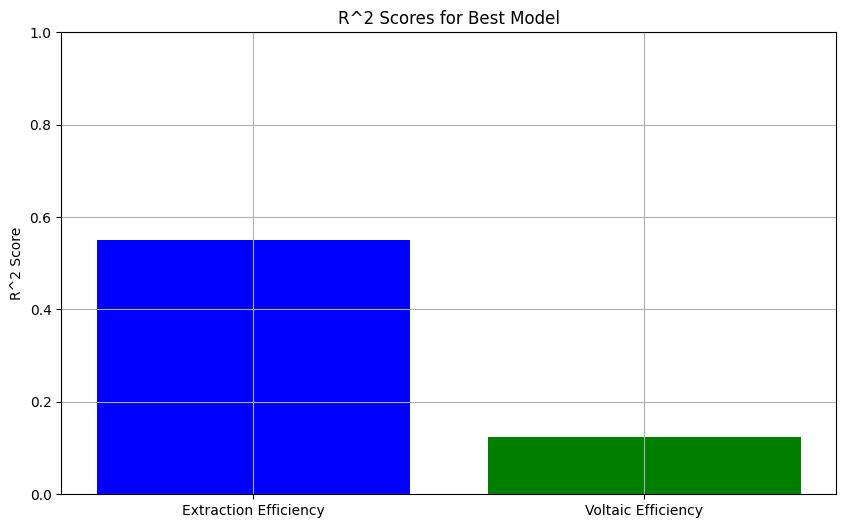

In [142]:
# Plot Hyperparameters and Corresponding R^2 Scores
plt.figure(figsize=(10, 6))
plt.bar(['Extraction Efficiency', 'Voltaic Efficiency'], [r2_extraction, r2_voltaic], color=['blue', 'green'])
plt.title("R^2 Scores for Best Model")
plt.ylabel("R^2 Score")
plt.ylim(0, 1)  # R^2 scores range from 0 to 1
plt.grid()
plt.show()

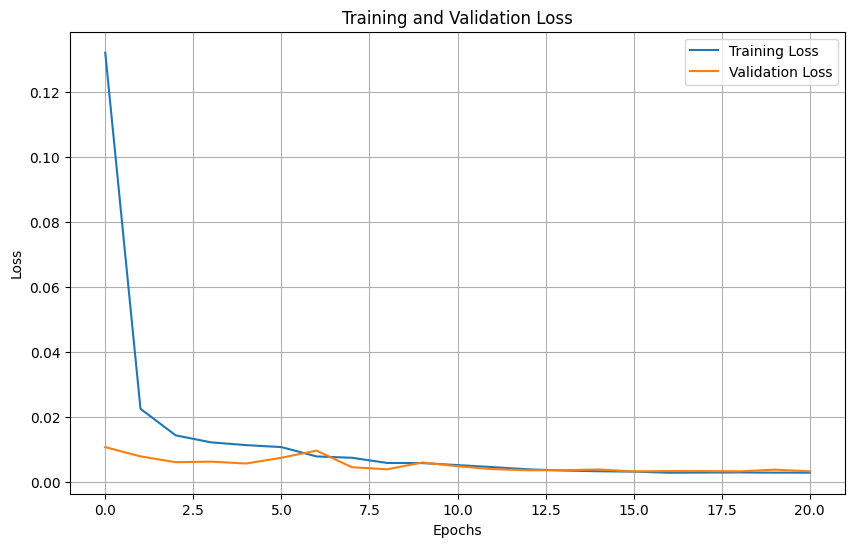

In [143]:
# Training and Validation Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

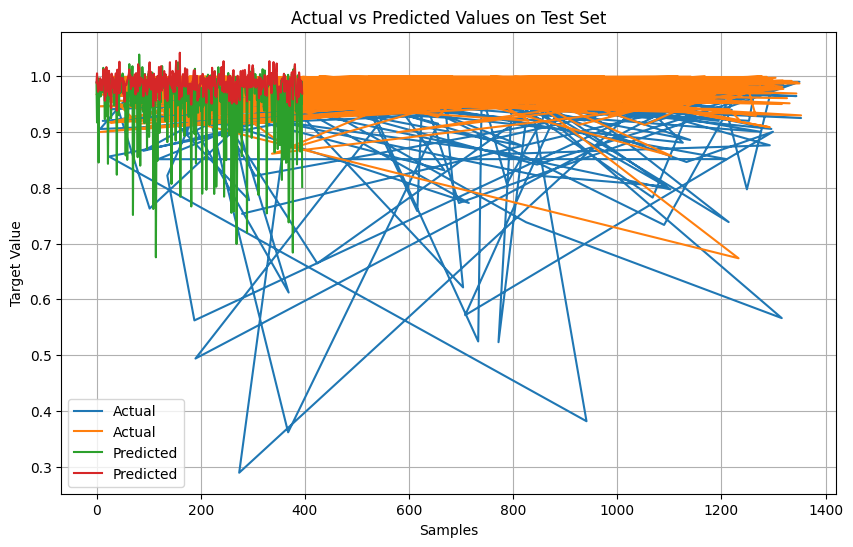

In [144]:
# Test Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Values on Test Set")
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.legend()
plt.grid()
plt.show()

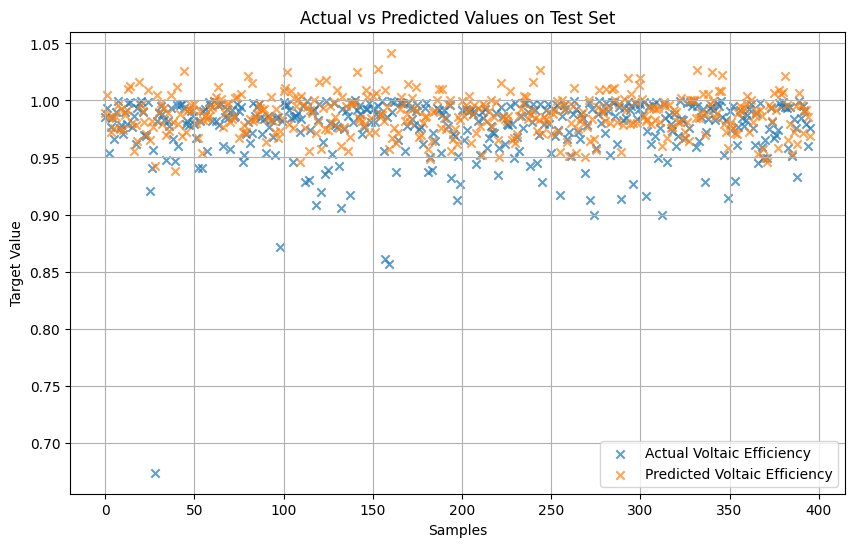

In [145]:
# Test Predictions vs Actual with Dots
plt.figure(figsize=(10, 6))

'''# Scatter plot for Actual "Extraction Efficiency"
plt.scatter(
    range(len(y_test["Extraction Efficiency"])),
    y_test["Extraction Efficiency"],
    label='Actual Extraction Efficiency',
    marker='o',
    alpha=0.7
)'''

# Scatter plot for Actual "Voltaic Efficiency"
plt.scatter(
    range(len(y_test["Voltaic Efficiency"])),
    y_test["Voltaic Efficiency"],
    label='Actual Voltaic Efficiency',
    marker='x',
    alpha=0.7
)

'''# Scatter plot for Predicted "Extraction Efficiency" (use column index 0)
plt.scatter(
    range(len(y_pred)),
    y_pred[:, 0],  # Use column index 0 for "Extraction Efficiency"
    label='Predicted Extraction Efficiency',
    marker='o',
    alpha=0.7
)
'''
# Scatter plot for Predicted "Voltaic Efficiency" (use column index 1)
plt.scatter(
    range(len(y_pred)),
    y_pred[:, 1],  # Use column index 1 for "Voltaic Efficiency"
    label='Predicted Voltaic Efficiency',
    marker='x',
    alpha=0.7
)

# Adding labels, title, and grid
plt.title("Actual vs Predicted Values on Test Set")
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.legend()
plt.grid()
plt.show()
